In [ ]:
# !pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 48.0 MB/s eta 0:00:00


In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys

    !git clone https://github.com/facebookresearch/segment-anything-2.git
    !cd segment-anything-2; pip install -e .
    !cd segment-anything-2/checkpoints; ./download_ckpts.sh
    !cd segment-anything-2/; python setup.py build_ext --inplace

    !{sys.executable} -m pip install opencv-python matplotlib


    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg


## based on your colab configurations, you might need to restart runtime in order for the installation to take effect.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1)

    ax.imshow(img)

In [ ]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))

In [ ]:
import os
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model_size_dict = {
    'tiny': 't',
    'small': 's',
    'base_plus': 'b+',
    'large': 'l'
}

# customizable
MODEL_SIZE = 'large'
SAM_DIR = 'segment-anything-2'

checkpoint = os.path.join(SAM_DIR, f"checkpoints/sam2_hiera_{MODEL_SIZE}.pt")
model_cfg = f"sam2_hiera_{model_size_dict[MODEL_SIZE]}.yaml"

sam2 = build_sam2(model_cfg, checkpoint, device ='cuda', apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

/content/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
masks = mask_generator.generate(image)

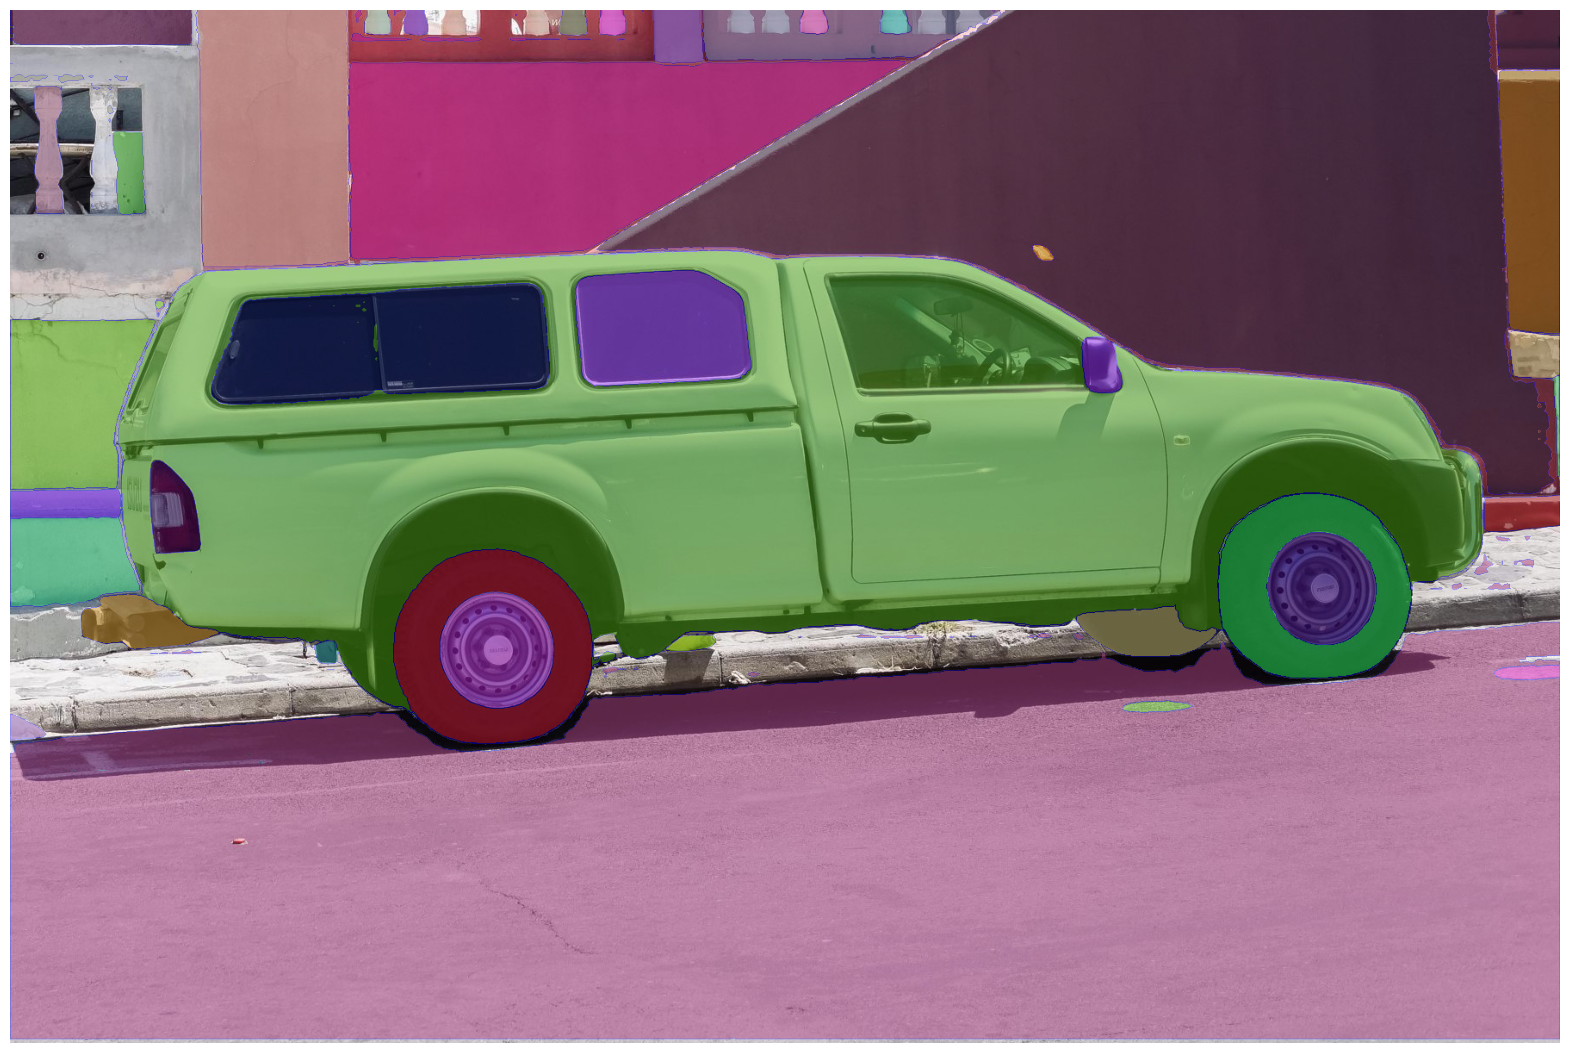

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
m = geemap.Map()
point = ee.Geometry.Point(-89.7707, 41.8188)
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)


dataset = (
    ee.ImageCollection('COPERNICUS/S2')
    .filterDate('2015-06-01', '2015-08-30')
    .map(mask_s2_clouds)
)
image = dataset.first()

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}
import folium
m = geemap.Map()

m.centerObject(point, 14)
m.add_layer(dataset.median(), visualization, 'RGB')
m.addLayerControl()

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
bbox = m.user_roi_coords() # [west, south, east, north]
if bbox is None:
    bbox = [-89.7974, 41.8027, -89.7575, 41.8251]
bbox

[-89.7974, 41.8027, -89.7575, 41.8251]

In [ ]:
# prompt: read two images from file, the first is annotations.tif, the other is SouthAmerica_Soybean_2021.tif. import them as numpy arrays.
# The soybean data is a very large file with 30 billion pixels. So I will need a function that only reads certain ranges of the  images, like using x_range and y_range.

import rasterio
import numpy as np

def read_image(file_path):
    return rasterio.open(file_path).read().transpose(1,2,0)

def read_image_subset(file_rio, x_range=None, y_range=None, output_path=None):
    """
    Reads a subset of an image from a file and saves it as a TIFF file if output_path is provided.

    Args:
        file_rio: The open rasterio dataset object.
        x_range: A tuple containing the starting and ending x coordinates of the subset.
        y_range: A tuple containing the starting and ending y coordinates of the subset.
        output_path: The path to save the subset image as a TIFF file.

    Returns:
        A NumPy array containing the subset of the image.
    """

    src = file_rio
    # Read the subset of the image
    if x_range is None or y_range is None:
        subset = src.read(1)
        window = None
    else:
        width = x_range[1] - x_range[0]
        height = y_range[1] - y_range[0]
        col_off = x_range[0]
        row_off = y_range[0]
        window = rasterio.windows.Window(col_off, row_off, width, height)
        subset = src.read(1, window=window)

    # Save the subset as a TIFF file if output_path is provided
    if output_path:
        profile = src.profile
        profile.update({
            'height': height if window else src.height,
            'width': width if window else src.width,
            'transform': rasterio.windows.transform(window, src.transform) if window else src.transform
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(subset, 1)

    return subset

def wgs_bbox_to_image_coords(file_rio, wgs_bbox):
    wgs_bbox # w, s, e, n
    raster_crs = file_rio.crs

    # Convert the raster bbox to pixel coordinates
    ulx, uly = rasterio.transform.rowcol(file_rio.transform, wgs_bbox[0], wgs_bbox[3])
    lrx, lry = rasterio.transform.rowcol(file_rio.transform, wgs_bbox[2], wgs_bbox[1])

    # Return the pixel coordinates
    return [ulx, uly, lrx, lry]

def image_bbox_to_ranges(bbox):
    return (bbox[1], bbox[3]), (bbox[0], bbox[2])

In [ ]:
import json
def generate_geojson_string(west, south, east, north):
    """
    Generates a geojson string based on the bounding box coordinates.

    Args:
        west: The westernmost coordinate of the bounding box.
        south: The southernmost coordinate of the bounding box.
        east: The easternmost coordinate of the bounding box.
        north: The northernmost coordinate of the bounding box.

    Returns:
        A geojson string representing the bounding box.
    """

    # Define the geojson object.
    geojson = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "properties": {},
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [west, south],
                            [east, south],
                            [east, north],
                            [west, north],
                            [west, south]
                        ][::-1]
                    ]
                }
            }
        ]
    }

    geojson=geojson['features'][0]['geometry']

    # Convert the geojson object to a string.
    #   geojson_string = json.dumps(geojson)

    #   return geojson_string
    return geojson

In [ ]:
rgb_bands = dataset.select(['B4', 'B3', 'B2']).filterBounds(generate_geojson_string(*bbox))
rgb_bands.size()

In [ ]:
geemap.ee_export_image(
    rgb_bands.median(), 'sample.tif', region=generate_geojson_string(*bbox),
    scale=10, unzip=True, crs='EPSG:3857'#, format='GEO_TIFF',
)

Generating URL ...
Please wait ...
Data downloaded to /content/sample.tif


In [ ]:
geemap.ee_export_image(
    cdl_2021, 'CDL2021.tif', region=generate_geojson_string(*bbox),
    scale=10, unzip=True, crs='EPSG:3857'#, format='GEO_TIFF',
)

Generating URL ...
Please wait ...
Data downloaded to /content/CDL2021.tif


In [ ]:
def stretch_image(image):
    """
    Stretches a NumPy image by band on its 2%-98% percentile.

    Args:
        image: A NumPy array representing the image.

    Returns:
        A NumPy array representing the stretched image.
    """

    # Calculate the 2nd and 98th percentiles of each band.
    percentiles = np.percentile(image, [2, 98], axis=(0, 1))

    # Stretch the image by band.
    stretched_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        stretched_image[:, :, i] = (image[:, :, i] - percentiles[0, i]) / (percentiles[1, i] - percentiles[0, i])

    stretched_image = np.clip(stretched_image, 0, 1)

    return stretched_image

In [ ]:
import rasterio.warp
def align_images(src_path, ref_path, output_path):
    """
    Aligns the source image to the reference image and saves the result.

    Args:
        src_path: The path to the source image that needs to be aligned.
        ref_path: The path to the reference image.
        output_path: The path to save the aligned image.

    Returns:
        None
    """

    with rasterio.open(ref_path) as ref:
        ref_transform = ref.transform
        ref_crs = ref.crs
        ref_width = ref.width
        ref_height = ref.height

        with rasterio.open(src_path) as src:
            src_transform = src.transform
            src_crs = src.crs
            src_width = src.width
            src_height = src.height

            # Create the destination array
            destination = np.empty((src.count, ref_height, ref_width), dtype=src.dtypes[0])

            # Reproject and resample the source image to match the reference image
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=destination[i - 1],
                    src_transform=src_transform,
                    src_crs=src_crs,
                    dst_transform=ref_transform,
                    dst_crs=ref_crs,
                    resampling=rasterio.warp.Resampling.bilinear
                )


            profile = ref.profile
            profile.update({
                'count': src.count
            })
            # Save the aligned image
            with rasterio.open(output_path, 'w', **profile) as dst:
                for i in range(1, src.count + 1):
                    dst.write(destination[i - 1], i)


In [ ]:
import cv2
from scipy.ndimage import distance_transform_edt

def distance2contour(mask_seg):
    res = distance_transform_edt(mask_seg)
    res = (res - np.min(res)) / (np.max(res) - np.min(res))
    res = (res * 255).astype(np.uint8)
    # return np.dstack([res, res, res])
    return res

# convert image to binary image
def binary_image(image):
    gray = np.mean(image, axis=2)
    gray = gray > 0.5*255
    gray = gray.astype(np.uint8)
    return gray

# find disjoint islands (bright regions)
def instance_image(image):
    gray = binary_image(image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(gray, connectivity=4)

    return [output==i for i in range(1, nb_components)]

In [ ]:
s2_image = rasterio.open("sample.tif").read().transpose(1,2,0)
s2_image = stretch_image(s2_image)

In [ ]:
SAM_VERSION = 2
if SAM_VERSION == 1:
    import sys
    sys.path.append("..")
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

    sam_checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"

    device = "cuda"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    mask_generator = SamAutomaticMaskGenerator(sam)
else:
    from sam2.build_sam import build_sam2
    from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator as SamAutomaticMaskGenerator

    model_size_dict = {
        'tiny': 't',
        'small': 's',
        'base_plus': 'b+',
        'large': 'l'
    }

    # customizable
    MODEL_SIZE = 'base_plus'
    SAM_DIR = 'segment-anything-2'

    checkpoint = os.path.join(SAM_DIR, f"checkpoints/sam2_hiera_{MODEL_SIZE}.pt")
    model_cfg = f"sam2_hiera_{model_size_dict[MODEL_SIZE]}.yaml"

    sam = build_sam2(model_cfg, checkpoint, device ='cuda', apply_postprocessing=False)
    mask_generator = SAM2AutomaticMaskGenerator(sam)

In [ ]:
def distance2contour(mask_seg):
    res = distance_transform_edt(mask_seg)
    res = (res - np.min(res)) / (np.max(res) - np.min(res))
    res = (res * 255).astype(np.uint8)
    return np.dstack([res, res, res])
# convert image to binary image
def binary_image(image):
    gray = np.mean(image, axis=2)
    gray = gray > 0.5*255
    gray = gray.astype(np.uint8)
    return gray

# find disjoint islands (bright regions)
def instance_image(image):
    gray = binary_image(image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(gray, connectivity=4)

    return [output==i for i in range(1, nb_components)]

def get_instance_masks(sam_predictor, image, points):
    masks_all = []
    quality_all = []
    lowres_logits_all = []
    for i in tqdm(range(0, len(points), 30), desc='Batch Instance Mask (Hover)'):
        right = min(i + 30, len(points))
        transformed_points = sam_predictor.transform.apply_coords_torch(torch.from_numpy(np.expand_dims(points[i:right], axis=1)), torch.from_numpy(image).shape[:2])
        masks, quality, lowres_logits = sam_predictor.predict_torch(
            point_coords=transformed_points.to(device),
            point_labels=torch.ones((len(transformed_points), 1)).to(device),
            multimask_output=True
        )
        masks_all.append(masks.detach().cpu())
        quality_all.append(quality.detach().cpu())
        lowres_logits_all.append(lowres_logits.detach().cpu())
    masks_all = np.concatenate(masks_all, axis=0)
    quality_all = np.concatenate(quality_all, axis=0)
    lowres_logits_all = np.concatenate(lowres_logits_all, axis=0)

    masks_all = np.reshape(masks_all, (-1, *masks_all.shape[2:]))
    quality_all = np.reshape(quality_all, (-1, *quality_all.shape[2:]))
    lowres_logits_all = np.reshape(lowres_logits_all, (-1, *lowres_logits_all.shape[2:]))

    return masks_all, quality_all, lowres_logits_all

def structure_mask_list(masks_all, quality_all, lowres_logits_all=None, labels=None):
    mask_list = []
    for i in tqdm(range(len(masks_all)), desc='structure_mask_list'):
        quaulity = quality_all[i]#.cpu().numpy()
        if quaulity < 0.8:
            continue
        mask_bm = masks_all[i]#.cpu().numpy()
        area = np.sum(mask_bm)
        if area < 300:
            continue
        if area > mask_bm.shape[0] * mask_bm.shape[1] * 0.2:
            continue

        mask = {
            'mask': mask_bm,
            'quality': quaulity,
            # 'lowres_logits': lowres_logits_all[i],#.cpu().numpy(),
            'area': area,
        }
        mask_list.append(mask)
        if lowres_logits_all is not None:
            mask['lowres_logits'] = lowres_logits_all[i]

    mask_list = sorted(mask_list, key=lambda x: x['area'], reverse=True)
    return mask_list
def perimeter(mask):
    # guideline: perimenter is determined by the the sum of the number of pixels that are different to its 4 neighbors

    # pad the mask with 0s
    mask = np.pad(mask, ((1, 1), (1, 1)), mode='constant', constant_values=0)
    # find the difference between the mask and its 4 neighbors
    diff = np.abs(mask[1:-1, 1:-1].astype(int) - mask[:-2, 1:-1].astype(int)) + \
        np.abs(mask[1:-1, 1:-1].astype(int) - mask[2:, 1:-1].astype(int)) + \
        np.abs(mask[1:-1, 1:-1].astype(int) - mask[1:-1, :-2].astype(int)) + \
        np.abs(mask[1:-1, 1:-1].astype(int) - mask[1:-1, 2:].astype(int))
    # sum up the difference
    perimeter = np.sum(diff)
    return perimeter

def calculate_perimeter(masks_st):
    for m in masks_st:
        # m['perimeter'] = np.sum(distance_transform_edt(m['mask']) == 1)
        m['perimeter'] = perimeter(m['mask'])
        m['perimeter_ratio'] = m['perimeter'] / m['area']
    # return masks_st
def standard_peri_ratio(masks_st):
    for m in masks_st:
        # calculate the standard perimeter ratio
        # the standard perimeter ratio is the ratio between the perimeter of the mask and the perimeter of a circle with the same area
        # the perimeter of a circle with area A is 2 * sqrt(pi * A)
        standard_perimeter = 2 * np.sqrt(np.pi * m['area'])
        m['standard_perimeter_ratio'] = m['perimeter'] / standard_perimeter

def hist_standard_peri_ratio(masks_st, title=''):
    fig, ax = plt.subplots(ncols=2)
    ax[0].hist([m['standard_perimeter_ratio'] for m in masks_st], bins=100)
    if not title:
        title = 'standard_perimeter_ratio'
    ax[0].set_title(title)
    ax[1].hist([m['area'] for m in masks_st], bins=100)
    fig.show()


def filter_mask(masks_st, area_thresh_gt=None, area_thresh_lt=None, area_ignore_shape_thresh=None, quality_thresh=None, standard_perimeter_ratio_thresh_gt=None, standard_perimeter_ratio_thresh_lt=None):
    masks = []
    for m in masks_st:
        if area_thresh_gt is not None and m['area'] <= area_thresh_gt:
            continue
        if area_thresh_lt is not None and m['area'] >= area_thresh_lt:
            continue
        if quality_thresh is not None and m['quality'] < quality_thresh:
            continue
        if (area_ignore_shape_thresh is not None and m['area'] >= area_ignore_shape_thresh) or (area_ignore_shape_thresh is None):
            if standard_perimeter_ratio_thresh_gt is not None and m['standard_perimeter_ratio'] <= standard_perimeter_ratio_thresh_gt:
                continue
            if standard_perimeter_ratio_thresh_lt is not None and m['standard_perimeter_ratio'] >= standard_perimeter_ratio_thresh_lt:
                continue
        masks.append(m)
    return masks

def compute_iou(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if intersection == 0:
        return 0
    union = np.sum(mask1) + np.sum(mask2) - intersection
    return intersection / union

def binary_region_trimming(masks_st, image):
    for m in masks_st:
        m['mask'] = m['mask'] * (np.mean(image, axis=-1) > 0.5*255)
        m['area'] = np.sum(m['mask'])

def moving_window(image, window_size=256, stride=128):
    windows = []
    origins = []
    h, w = image.shape[:2]
    if type(window_size) == int:
        window_size = (window_size, window_size)
    if type(stride) == int:
        stride = (stride, stride)
    for i in range(0, h-window_size[0], stride[0]):
        for j in range(0, w-window_size[1], stride[1]):
            # yield image[i:i+window_size, j:j+window_size], (i, j)
            windows.append(image[i:i+window_size[0], j:j+window_size[1]])
            origins.append((j, i, window_size[1], window_size[0])) # given in (x, y, w, h) format, same as SAM
    return windows, origins

def draw_window_border(origins, ax=None):
    if ax is None:
        ax = plt.gca()
    for origin in origins:
        x, y, w, h = origin
        ax.add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))
    return ax

In [ ]:
def show_anns(anns, ax=None, id_markup=False, one_point=False, cropped_anns=False, in_window=False):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    if ax is None:
        ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    bbox_attr = 'bbox_in_window' if in_window else 'bbox'
    for i_ann, ann in enumerate(sorted_anns):
        if one_point:
            m = ann['mask']
        else:
            m = ann['segmentation']
        # print(m.shape)
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        # ax.imshow(np.dstack((img, m*0.35)))
        if not cropped_anns:
            ax.imshow(np.dstack((img, m*0.35)))
        else:
            ax.imshow(np.dstack((img, m*0.35)), extent=(-0.5 + ann[bbox_attr][0], -0.5 + ann[bbox_attr][0] + ann[bbox_attr][2], -0.5 + ann[bbox_attr][1] + ann[bbox_attr][3], -0.5 + ann[bbox_attr][1]))
        if id_markup:
            ax.text(ann[bbox_attr][0] + ann[bbox_attr][2]/2, ann[bbox_attr][1] + ann[bbox_attr][3]/2, str(i_ann), color='white', fontsize=8)

In [ ]:
mask_generator_window = SamAutomaticMaskGenerator(
    model=sam2,
    points_per_side=32,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.7,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

def get_bbox(mask):
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print('Warning: no contour found')
        return 0, 0, 0, 0
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h

def get_bbox_mask_list(mask_st, origin=None):
    for m in mask_st:
        bbox = get_bbox(m['mask'])
        m['bbox_in_window'] = bbox
        if origin:
            m['bbox'] = (bbox[0] + origin[0], bbox[1] + origin[1], bbox[2], bbox[3])

import scipy.ndimage
import skimage.morphology
def get_masks_window_everything(w, origin, area_thresh_gt=100):
    masks_window = mask_generator_window.generate(w)

    if len(w.shape) == 3:
        non_black_area = np.sum(w, axis=-1) > 0
    else:
        non_black_area = w > 0

    to_delete = []
    for m in masks_window:
        m['mask'] = m['segmentation']
        del m['segmentation']

        # m['mask'] = scipy.ndimage.binary_fill_holes(m['mask'])
        m['mask'] = skimage.morphology.remove_small_holes(m['mask'], area_threshold=300)
        # if np.mean(w[m['mask']]) < 2/255*255:
        #     to_delete.append(m)
        #     continue
        # if np.sum(m['mask'] * non_black_area)/np.sum(non_black_area) > 0.5:
        #     to_delete.append(m)
        #     continue

    for m in to_delete:
        masks_window.remove(m)
    # binary_region_trimming(masks_window, w)
    get_bbox_mask_list(masks_window, origin=origin)
    for m in masks_window:
        m['mask'] = m['mask'][m['bbox_in_window'][1]:(m['bbox_in_window'][1]+m['bbox_in_window'][3]), m['bbox_in_window'][0]:(m['bbox_in_window'][0]+m['bbox_in_window'][2])]

    m['area'] = np.sum(m['mask'])
    calculate_perimeter(masks_window)
    standard_peri_ratio(masks_window)
    # good_masks = filter_mask(masks_window, area_thresh_gt=area_thresh_gt, area_thresh_lt=w.shape[0] * w.shape[1] * 0.001, standard_perimeter_ratio_thresh_lt=4)
    good_masks = filter_mask(masks_window, standard_perimeter_ratio_thresh_lt=4)

    sorted_anns = sorted(good_masks, key=(lambda x: x['area']), reverse=True)

    return good_masks

In [ ]:
windows = [s2_image]
origins = [(0, 0, *s2_image.shape[:2])]

masks = get_masks_window_everything(windows[0], origins[0])

In [ ]:
len(masks)

61

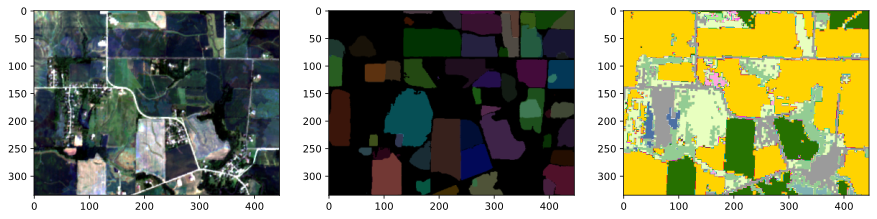

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 10))
ax[0].imshow(s2_image)
ax[1].imshow(s2_image*0)
show_anns(masks, ax[1], one_point=True, in_window=True, cropped_anns=1)

In [ ]:
with rasterio.open('result.tif', 'w', **{
    'driver': 'GTiff',
    'height': new_full_mask.shape[0],
    'width': new_full_mask.shape[1],
    'count': 1,
    'dtype': 'uint8',
    'crs': 'EPSG:3857',
    'transform': rasterio.open('sample.tif').transform
}) as dst:
    dst.write(new_full_mask, 1)

In [ ]:
zipfile_name = 'results_' + MODEL_SIZE + '.zip'

!mkdir results
!cp result.tif results/
!cp sample.tif results/
!cp CDL2021.tif results/
!cp result.svg results/
# !zip -r results.zip results
!zip -r {zipfile_name} results/

  adding: results/ (stored 0%)
  adding: results/CDL2021.tif (deflated 6%)
  adding: results/result.svg (deflated 31%)
  adding: results/result.tif (deflated 95%)
  adding: results/sample.tif (deflated 1%)


In [ ]:
!rm -r results